Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


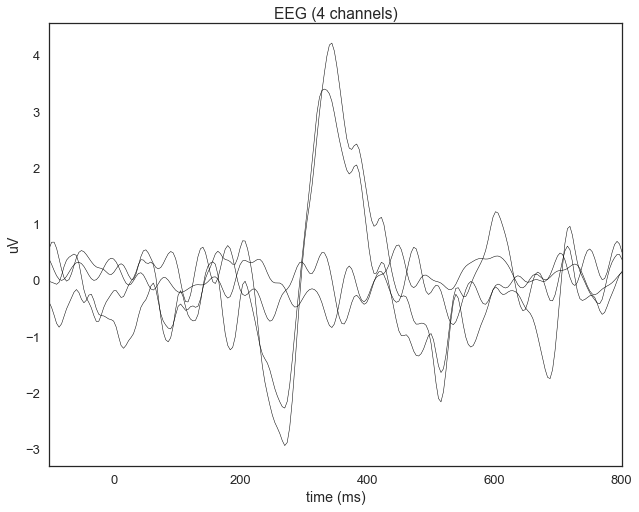

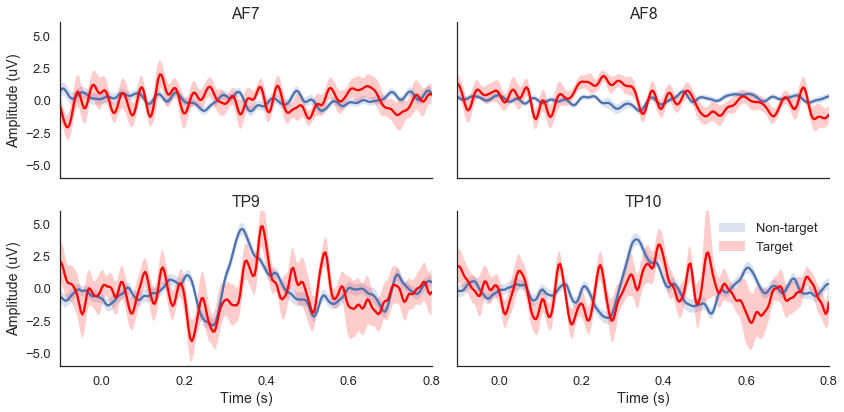

Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


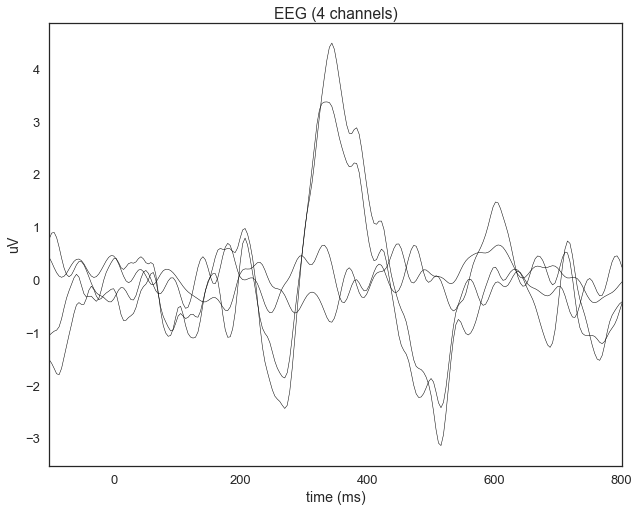

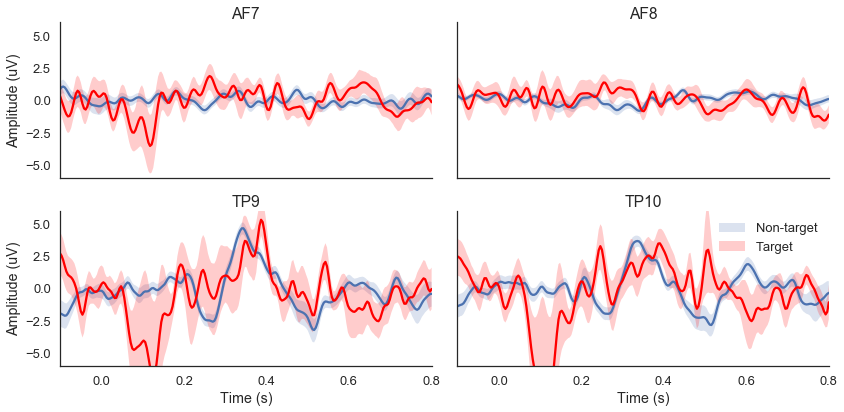

Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


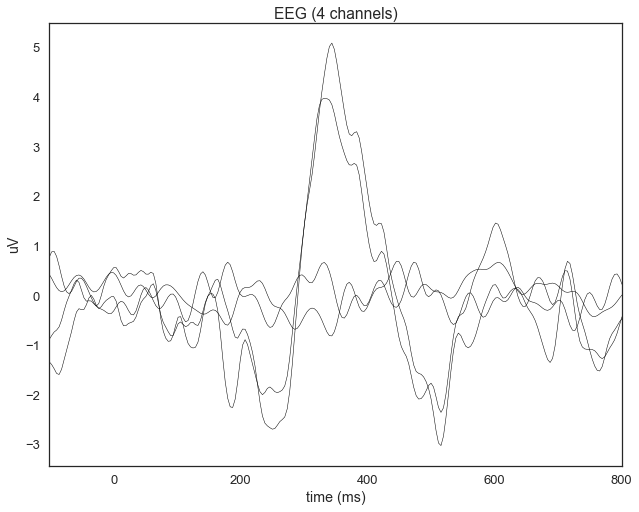

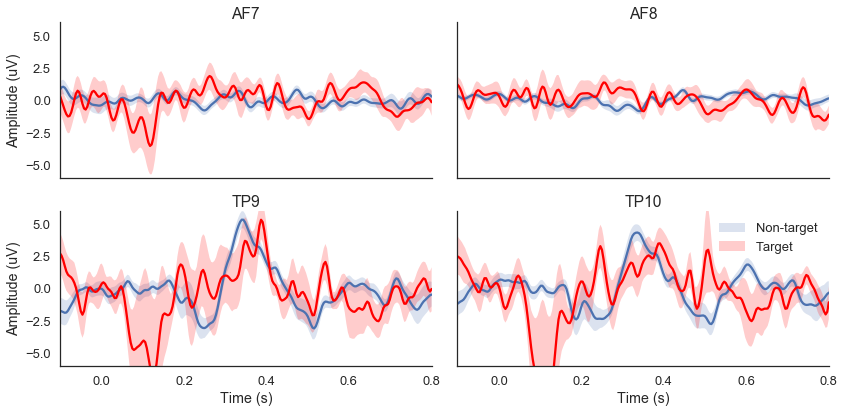

Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


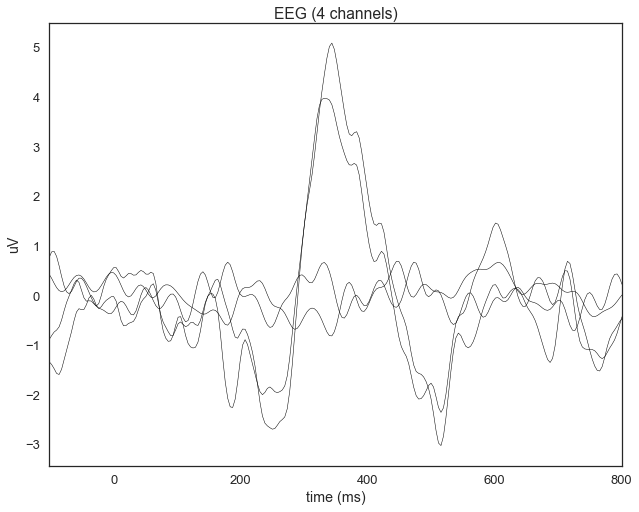

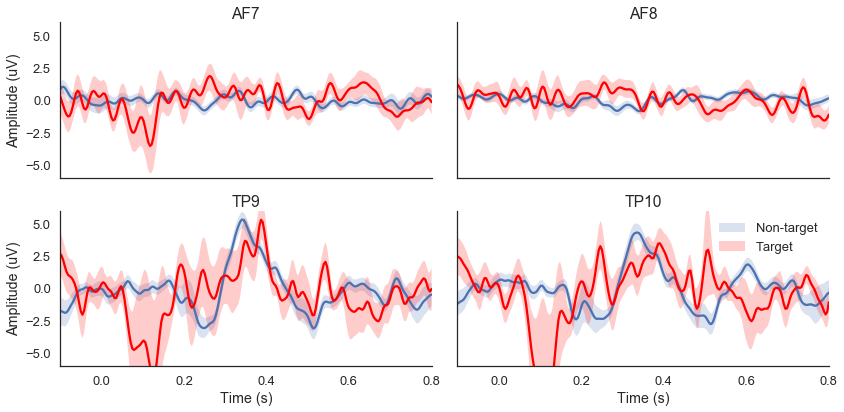

Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


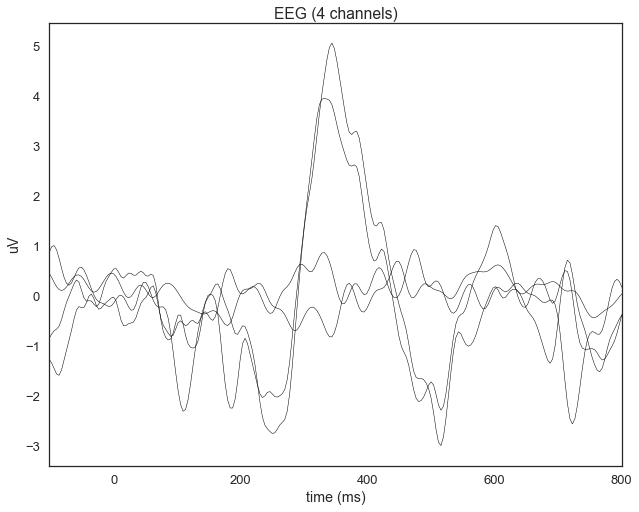

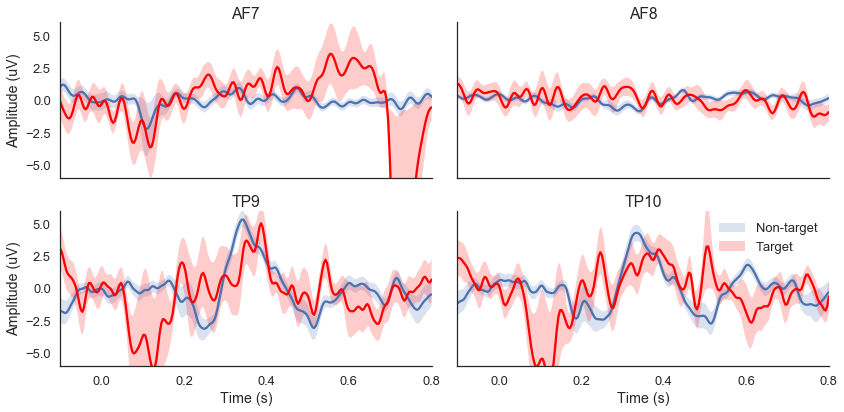

Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


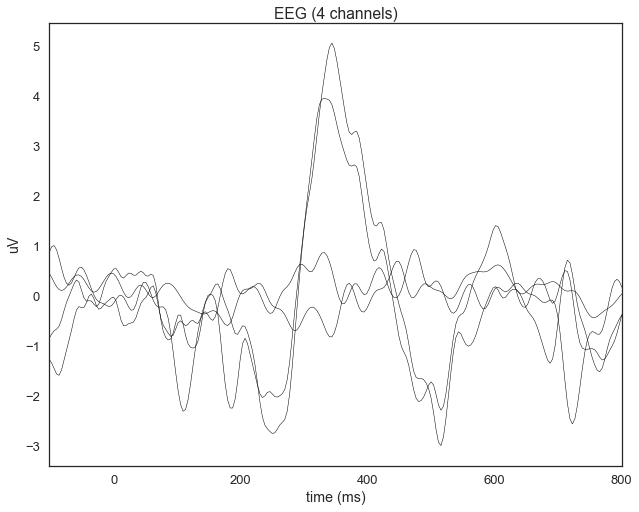

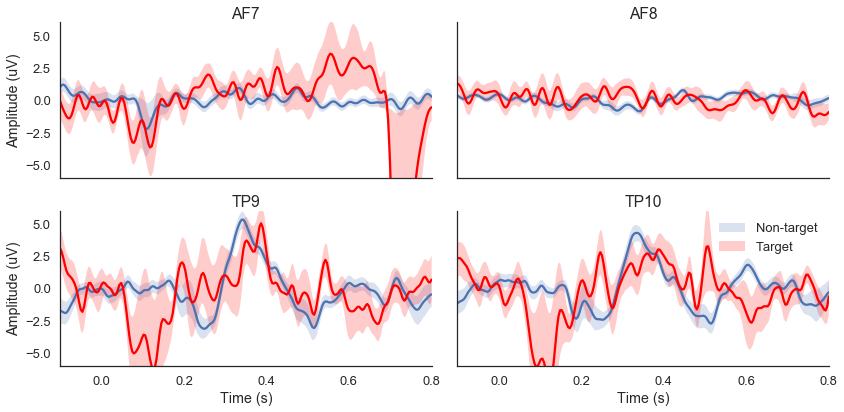

Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


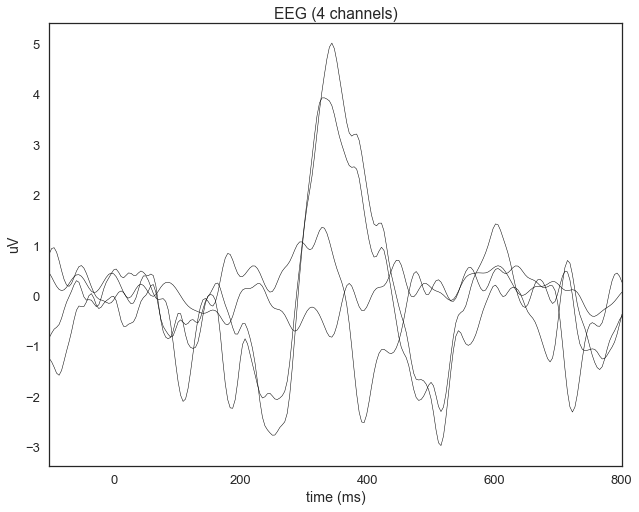

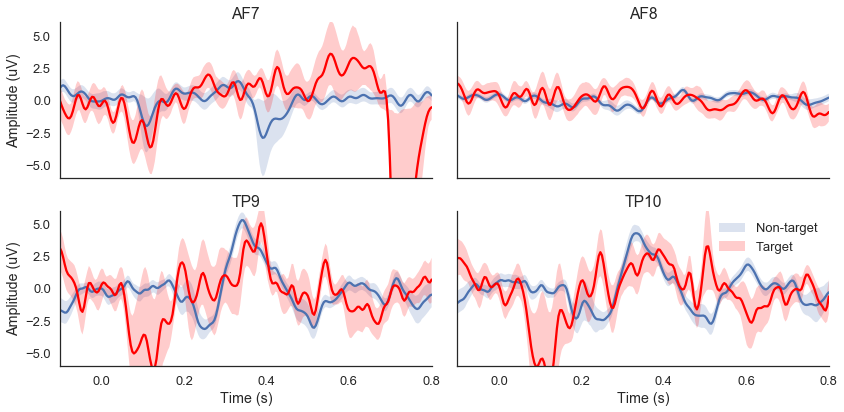

Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


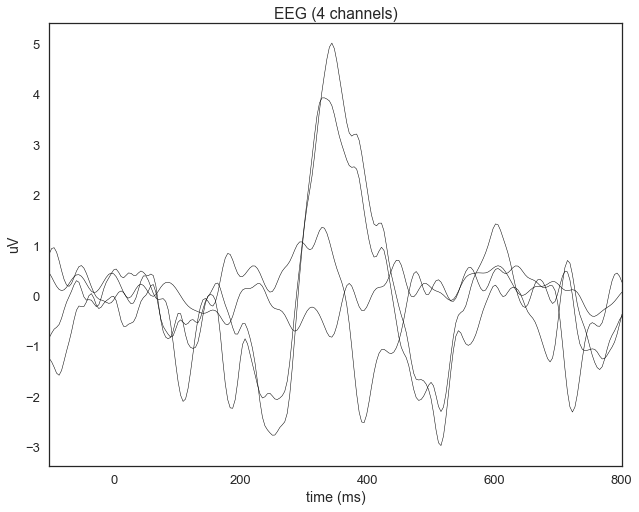

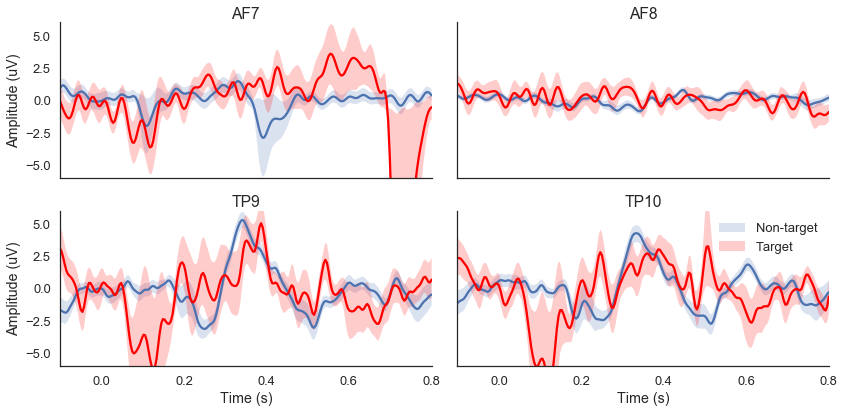

Creating RawArray with float64 data, n_channels=5, n_times=3072
    Range : 0 ... 3071 =      0.000 ...    11.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30336
    Range : 0 ... 30335 =      0.000 ...   118.496 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
204 events found
Events id: [1 2]


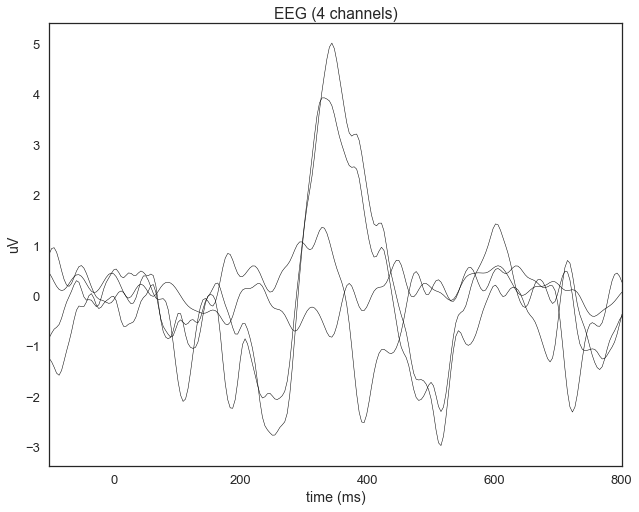

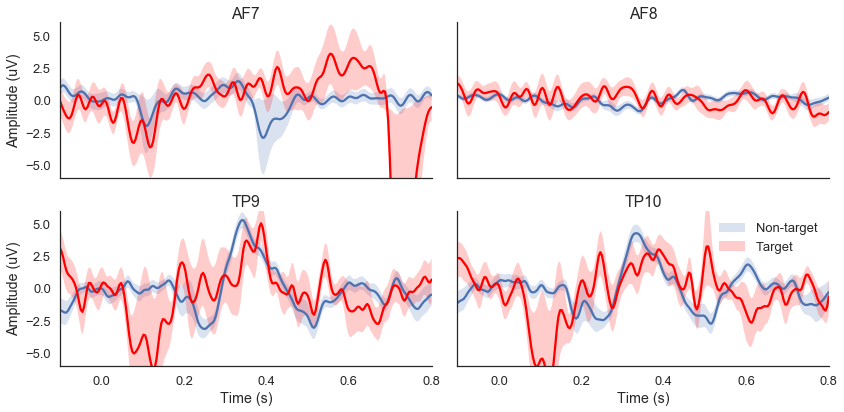

In [30]:
# p2 = p300_from_path('/Users/shiran/workspace/muse-lsl/data/visual/P300/subject%s/session%s/data_2017-02-04-15_45_13.csv' % (1, 1))
for i in range(1 ,10):
    reject = {'eeg': i*100e-6}
    p1 = p300_from_path('/Users/shiran/workspace/muse-lsl/data/visual/P300/shiran/muse_monitor_dogs/data_*.csv',reject)
    p1.show()

In [ ]:
# %load load_data.py
from glob import glob
import numpy as np
import mne
from mne import create_info, concatenate_raws, Epochs, find_events
from mne.io import RawArray
from mne.channels import read_montage
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


def describe_data(files):
    if len(files) == 0:
        print "no files found"
        return
    raw = get_raw(files)
    df = raw.to_data_frame()
    event_id = {'Non-Target': 1, 'Target': 2}
    reject = {'eeg': 100e-6}
    avg, epochs = clean_epochs(event_id, raw, 1, 30, reject)

    df.describe()
    avg.plot()
    avg.plot_image()

    for kind in event_id.keys():
        subset = epochs[kind]
        av = subset.average()
        ixs_plot = mne.pick_types(av.info, meg=False, eeg=True)
        _ = av.plot_joint(picks=ixs_plot, title=kind)


def get_raw(files):
    raw = []
    for file_name in files:
        # read the file
        data = pd.read_csv(file_name, index_col=0)
        sfreq = 256

        # name of each channels
        ch_names = list(data.columns)[0:4] + ['Stim']

        # type of each channels
        ch_types = ['eeg'] * 4 + ['stim']
        montage = read_montage('standard_1005')

        # get data and exclude Aux channel
        data = data.values[:, [0, 1, 2, 3, 5]].T

        # convert to Volts (from uVolts (microvolt) to volt
        # from the docs:
        # /muse/eeg is uV , floats, range: 0.0 - 1682.815 uV
        # 1uv == (10^-6) * (1 Volt)
        data[:-1] *= 1e-6

        # create mne objects
        info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
        raw.append(RawArray(data=data, info=info))

    # concatenates all raw objects
    raw = concatenate_raws(raw)
    return raw


def clean_epochs(event_id, raw, start, end, reject):
    # filter out events outside of start, end
    #  power line noise - 50 hz,
    raw.filter(start, end, method='iir')
    events = find_events(raw)

    epochs = Epochs(raw, events=events, event_id=event_id, tmin=-0.1, tmax=0.8, baseline=None,
                    reject=reject, preload=True, verbose=False, picks=[0, 1, 2, 3], add_eeg_ref=False)

    avg = epochs.average()
    avg.plot()

    return avg, epochs


def p300(epochs):
    epochs.pick_types(eeg=True)
    X = epochs.get_data() * 1e6
    times = epochs.times
    y = epochs.events[:, -1]

    sns.set_context('talk')
    sns.set_style('white')
    fig, axes = plt.subplots(2, 2, figsize=[12, 6], sharex=True, sharey=True)
    axes = [axes[1, 0], axes[0, 0], axes[0, 1], axes[1, 1]]

    for ch in range(4):
        sns.tsplot(X[y == 1, ch], time=times, n_boot=1000, ax=axes[ch])
        sns.tsplot(X[y == 2, ch], time=times, color='r', n_boot=1000, ax=axes[ch])
        axes[ch].set_title(epochs.ch_names[ch])
        axes[ch].set_ylim(-6, 6)

    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude (uV)')
    axes[-1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude (uV)')
    plt.legend(['Non-target', 'Target'])
    sns.despine()
    plt.tight_layout()
    return plt


def p300_from_path(path, reject):
    files = glob(path)
    raw = get_raw(files)
    event_id = {'Non-Target': 1, 'Target': 2}
    avg, epochs = clean_epochs(event_id, raw, 1, 30, reject)
    return p300(epochs)
